<a href="https://colab.research.google.com/github/kelgruber/hand-gesture-classification/blob/main/Kel_Gruber_Final_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Task 2: Build, Train and Evaluate Basic CNNs

Kel Gruber

## Dataset - Hand Gesture Classification

Goal of this project is build a model that correctly classifies images of 5 different hand gestures. Dataset consists of over 2650 digital colored images that belong to 5 classes: dislike, like, peace, one, and stop. 2500 images came from the crowdsourced HaGRID dataset and 150 images were taken by Kel Gruber and classmate volunteers following the Hagrid dataset's collection guidelines.

The 2500 images originally came from this [HaGRID Sample 30k 384p Dataset](https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p) on Kaggle, this sample contains 30,000 images and all 18 classes.

##1. Load Dataset
For reproducibility the dataset has been split before we begin into 3 sets, the training, validation and testing sets. The training set contains approximately 60% of the data for a total of 1590 images, 318 per class. The validation and testing sets each contain 20% of the data which is 530 images each with 106 images per class.

This task will be completed with the revised dataset from Task 1 with the cropped images. As shown in the Task 1 experiments the original data requires very deep models to learn due to the complexity of the complexity of the original images. In order to analyze and complete the hyperparameter experiments in this task it will be best to use the preprocessed dataset.

### Import libaries and connect to Drive

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Dataset from Drive and Unzip

In [ ]:
import zipfile
import os
zip_train = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/5390 Final Project/Cropped_Split_Data.zip')
zip_train.extractall('/tmp')
zip_train.close()

###Import Training, Validation, and Testing Datasets

In [ ]:
image_size = 100

image_generator = ImageDataGenerator(rescale=1./255)

training_data = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(training_data.image_shape)

validation_set = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(image_size , image_size ), batch_size=1, class_mode='categorical')
print(validation_set.image_shape)

testing_set = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/testing', target_size=(image_size , image_size), batch_size=1, class_mode='categorical')
print(testing_set.image_shape)

Found 1590 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)
Found 530 images belonging to 5 classes.
(100, 100, 3)


###View Some Examples from the Training Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

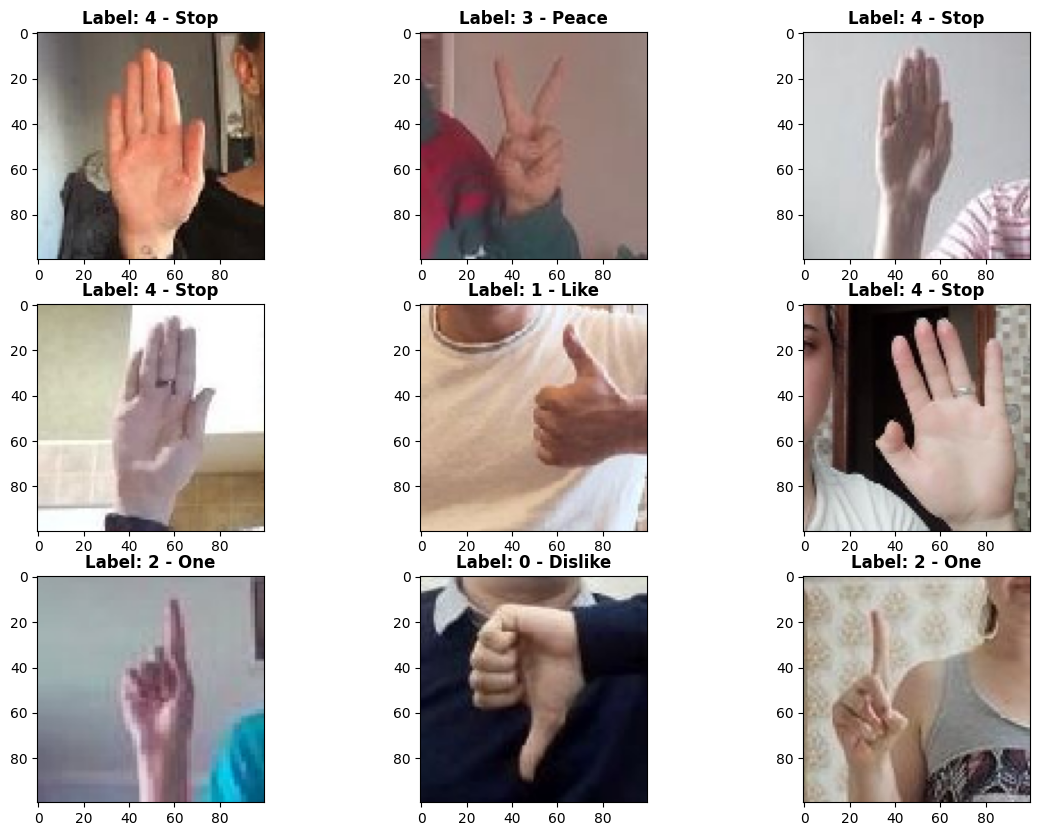

In [ ]:
i = 3
label_category = {0: "Dislike", 1: "Like", 2: "One", 3: "Peace", 4: "Stop"}

images = []
labels = []
for i in range(9):
    image, label = next(training_data)
    images.append(image)
    labels.append(label)

labels = np.array(labels)
labels = np.squeeze(labels)
labels = np.argmax(labels, axis=1)
labels = list(labels)

# Plotting the images
plt.figure(figsize=(14,10))
for i in range(0,9):
    row = i // 3  # Calculate row index
    column = i % 3  # Calculate column index
    plt.subplot(3, 3, i + 1)
    plt.title(f'Label: {labels[i]} - {label_category[labels[i]]}',fontweight='bold')
    plt.imshow(images[i].squeeze())
plt.show()

##2. Build an Base Model

Our goal in this phase is to design and build a model that obtains highest possible accuracy on the validation set. We will be utilizing early stopping and model checkpointing to prevent overfitting and experimenting with tuning the hyperparameters.

## Base Models from Task 1

###2.1 Basic Model 1

Model Structure:
- 3 Convolutional layers with 64, 32, and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (7,7) and (4,4) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [ ]:
model_1 = Sequential()

model_1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_1.add(layers.MaxPooling2D((7, 7)))
model_1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((4, 4)))
model_1.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_1.add( Flatten() )
model_1.add( Dense(5, activation = 'softmax' ) )

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 16)                0

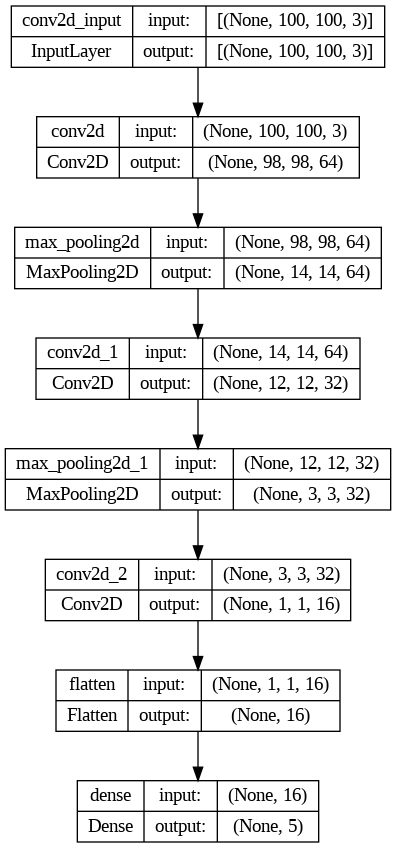

In [ ]:
tf.keras.utils.plot_model(model_1, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_1_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history1 = model_1.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.6140 - accuracy: 0.2127
Epoch 1: val_loss improved from inf to 1.60487, saving model to model_1_best.hdf5
1590/1590 [==============================] - 12s 7ms/step - loss: 1.6139 - accuracy: 0.2132 - val_loss: 1.6049 - val_accuracy: 0.2245
Epoch 2/100
1590/1590 [==============================] - ETA: 0s - loss: 1.4986 - accuracy: 0.3170
Epoch 2: val_loss improved from 1.60487 to 1.28315, saving model to model_1_best.hdf5
1590/1590 [==============================] - 10s 6ms/step - loss: 1.4986 - accuracy: 0.3170 - val_loss: 1.2832 - val_accuracy: 0.4849
Epoch 3/100
1585/1590 [============================>.] - ETA: 0s - loss: 1.1248 - accuracy: 0.5495
Epoch 3: val_loss improved from 1.28315 to 0.99991, saving model to model_1_best.hdf5
1590/1590 [==============================] - 11s 7ms/step - loss: 1.1238 - accuracy: 0.5503 - val_loss: 0.9999 - val_accuracy: 0.6434
Epoch 4/100
1588/1590 [========================

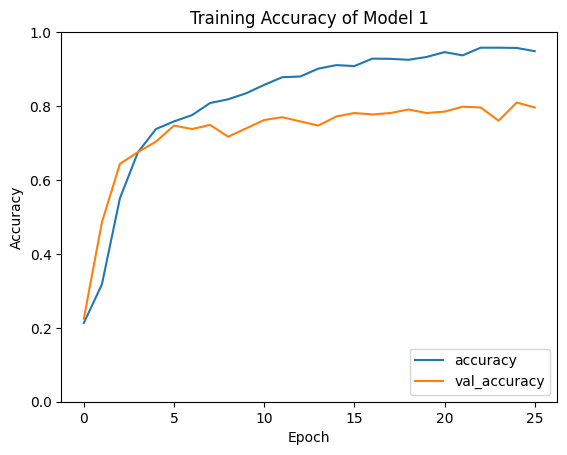

In [ ]:
plt.title('Training Accuracy of Model 1')
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

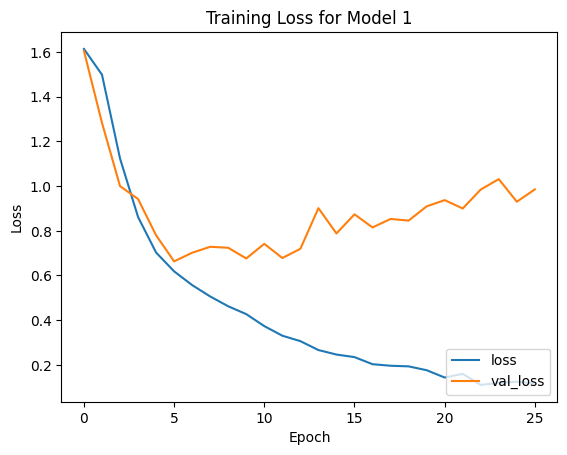

In [ ]:
plt.title('Training Loss for Model 1')
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_1.load_weights('model_1_best.hdf5')

In [ ]:
val_loss, val_acc = model_1.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 5s 9ms/step - loss: 0.6632 - accuracy: 0.7472
Accuracy: 74.71697926521301
Loss:0.6632041931152344


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_1.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7471698113207547
Precision: 0.7472145374037348
Recall: 0.7471698113207547
F1 Score: 0.7444457926875335


###2.2 Model 2

Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (4,4) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

Looking at the learning curves its easy to see that the prior model very quickly overfit the data. I thought it might be best to try a smaller model. I looked back at my Task 1 report and decided to try one of the smaller models with the hope that with model checkpointing and early stopping that the model will not overfit too quickly.

In [ ]:
model_2 = Sequential()

model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_2.add(layers.MaxPooling2D((4, 4)))
model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((4, 4)))
model_2.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_2.add( Flatten() )
model_2.add( Dense(5, activation = 'softmax' ) )

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 144)              

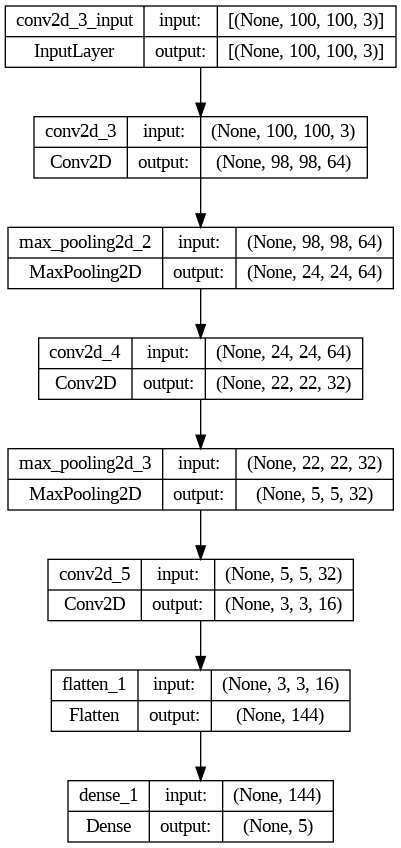

In [ ]:
tf.keras.utils.plot_model(model_2, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_2_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history2 = model_2.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1581/1590 [============================>.] - ETA: 0s - loss: 1.4820 - accuracy: 0.3378
Epoch 1: val_loss improved from inf to 1.22222, saving model to model_2_best.hdf5
1590/1590 [==============================] - 14s 8ms/step - loss: 1.4826 - accuracy: 0.3384 - val_loss: 1.2222 - val_accuracy: 0.4811
Epoch 2/100
1579/1590 [============================>.] - ETA: 0s - loss: 1.0878 - accuracy: 0.5776
Epoch 2: val_loss improved from 1.22222 to 1.06867, saving model to model_2_best.hdf5
1590/1590 [==============================] - 11s 7ms/step - loss: 1.0885 - accuracy: 0.5780 - val_loss: 1.0687 - val_accuracy: 0.5736
Epoch 3/100
1589/1590 [============================>.] - ETA: 0s - loss: 0.9635 - accuracy: 0.6186
Epoch 3: val_loss improved from 1.06867 to 0.95035, saving model to model_2_best.hdf5
1590/1590 [==============================] - 17s 10ms/step - loss: 0.9629 - accuracy: 0.6189 - val_loss: 0.9504 - val_accuracy: 0.6264
Epoch 4/100
1581/1590 [=======================

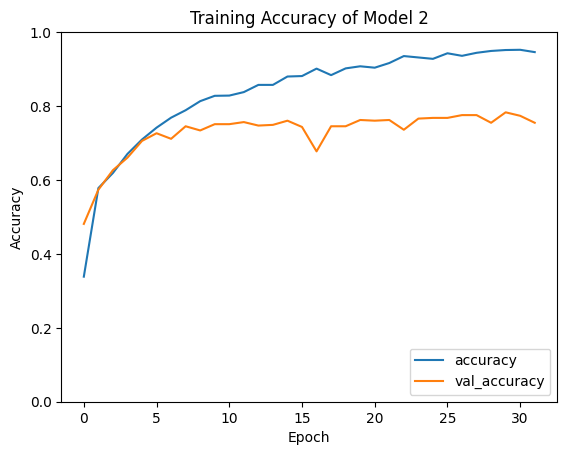

In [ ]:
plt.title('Training Accuracy of Model 2')
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

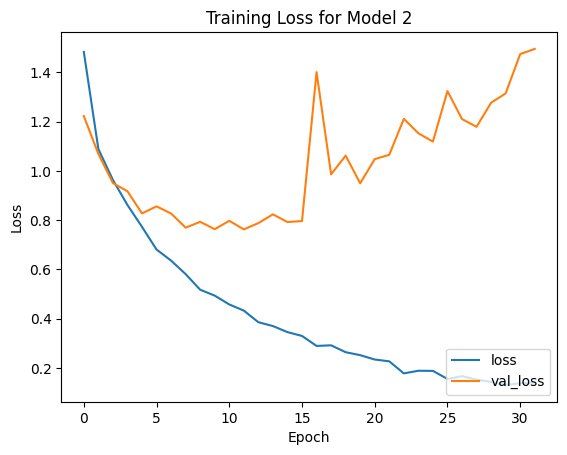

In [ ]:
plt.title('Training Loss for Model 2')
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_2.load_weights('model_2_best.hdf5')

In [ ]:
val_loss, val_acc = model_2.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.7622 - accuracy: 0.7566
Accuracy: 75.66037774085999
Loss:0.7621753215789795


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_2.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7566037735849057
Precision: 0.7522918425450683
Recall: 0.7566037735849057
F1 Score: 0.7530661232926793


## Experiments with Changing the Total layers in the Model

###2.3 Model 3 Adding more Layers

Model Structure:
- 5 Convolutional layers with 64, 64, 32, 32 and 16 kernels, each using a relu activation function
- 4 MaxPool layers that follow the first, second, third, and fourth convolutional layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

Model 2 did significantly better on the validation set but it is still overfitting, so I decided to try to reduce the parameters in the CNN more. I adjusted the max pooling layers to the max values I was able to try in Task 1 for this model.

In [ ]:
model_3 = Sequential()

model_3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2,2)))
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_3.add( Flatten() )
model_3.add( Dense(5, activation = 'softmax' ) )

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 10, 10, 32)       

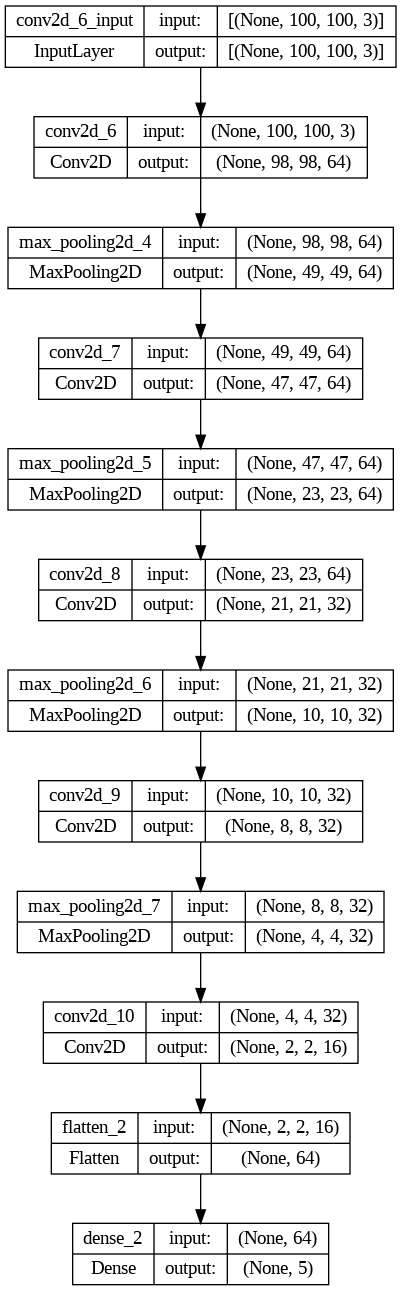

In [ ]:
tf.keras.utils.plot_model(model_3, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_3_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_3.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history3 = model_3.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1582/1590 [============================>.] - ETA: 0s - loss: 1.6118 - accuracy: 0.1909
Epoch 1: val_loss improved from inf to 1.60945, saving model to model_3_best.hdf5
1590/1590 [==============================] - 16s 8ms/step - loss: 1.6118 - accuracy: 0.1899 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/100
1588/1590 [============================>.] - ETA: 0s - loss: 1.6103 - accuracy: 0.1895
Epoch 2: val_loss did not improve from 1.60945
1590/1590 [==============================] - 13s 8ms/step - loss: 1.6103 - accuracy: 0.1893 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/100
1588/1590 [============================>.] - ETA: 0s - loss: 1.6103 - accuracy: 0.1883
Epoch 3: val_loss did not improve from 1.60945
1590/1590 [==============================] - 14s 9ms/step - loss: 1.6103 - accuracy: 0.1887 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/100
1590/1590 [==============================] - ETA: 0s - loss: 1.6103 - accuracy: 0.1830
Epoch 4: val_loss improved

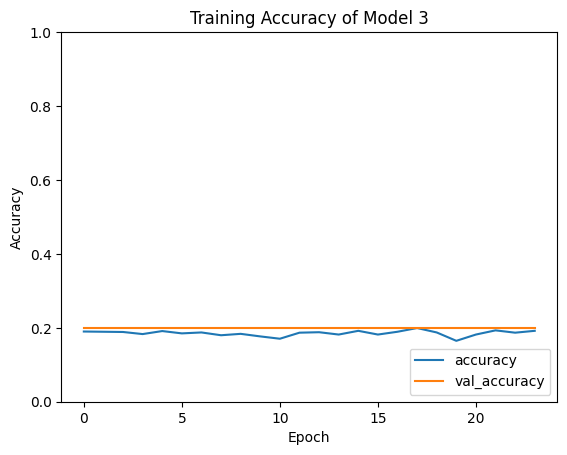

In [ ]:
plt.title('Training Accuracy of Model 3')
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

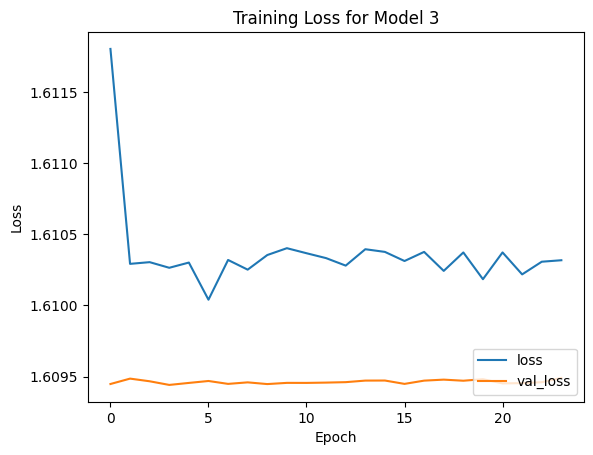

In [ ]:
plt.title('Training Loss for Model 3')
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_3.load_weights('model_3_best.hdf5')

In [ ]:
val_loss, val_acc = model_3.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 1.6094 - accuracy: 0.2000
Accuracy: 20.000000298023224
Loss:1.6094399690628052


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_3.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.2
Precision: 0.04000000000000001
Recall: 0.2
F1 Score: 0.06666666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###2.4 Model 4 VGG Inspired Model with Blocks

Model Structure:
- 3 Blocks consisting of Convolutional layers with 64, 128, and 256 kernels, each using a relu activation function and 3 Maxpool layers that follow the second, fourth  and 6th convolutional layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

In [ ]:
model_4 = Sequential()

model_4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add( Flatten() )
model_4.add( Dense(5, activation = 'softmax' ) )

model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 conv2d_39 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 conv2d_41 (Conv2D)          (None, 44, 44, 128)       147584    
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                

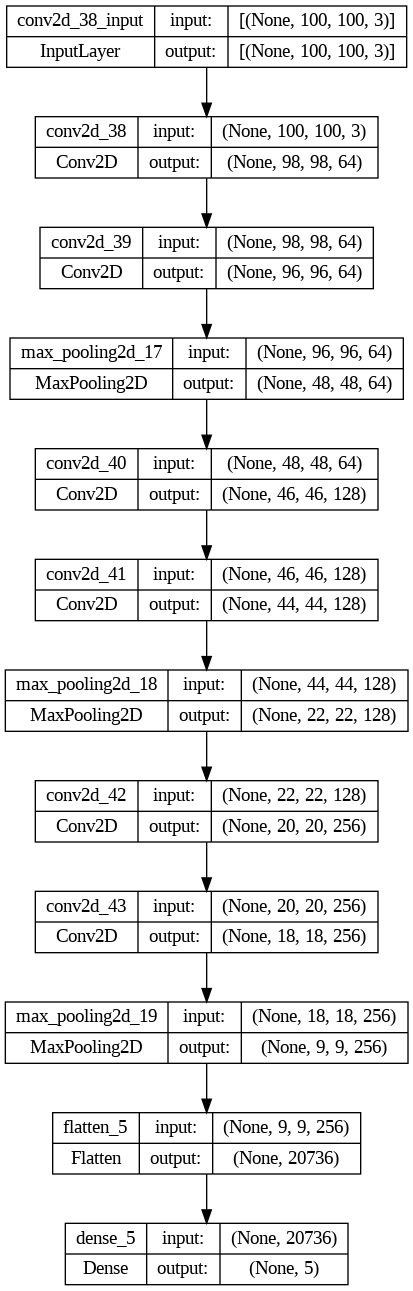

In [ ]:
tf.keras.utils.plot_model(model_4, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_4_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history4 = model_4.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1590/1590 [==============================] - ETA: 0s - loss: 1.6125 - accuracy: 0.1868
Epoch 1: val_loss improved from inf to 1.60949, saving model to model_4_best.hdf5
1590/1590 [==============================] - 22s 11ms/step - loss: 1.6125 - accuracy: 0.1868 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.6104 - accuracy: 0.1857
Epoch 2: val_loss improved from 1.60949 to 1.60946, saving model to model_4_best.hdf5
1590/1590 [==============================] - 20s 13ms/step - loss: 1.6104 - accuracy: 0.1855 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/100
1585/1590 [============================>.] - ETA: 0s - loss: 1.6104 - accuracy: 0.1886
Epoch 3: val_loss improved from 1.60946 to 1.60944, saving model to model_4_best.hdf5
1590/1590 [==============================] - 23s 14ms/step - loss: 1.6104 - accuracy: 0.1887 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 4/100
1585/1590 [=====================

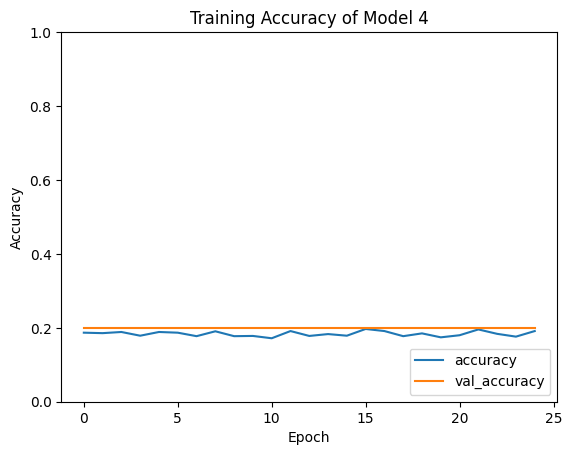

In [ ]:
plt.title('Training Accuracy of Model 4')
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

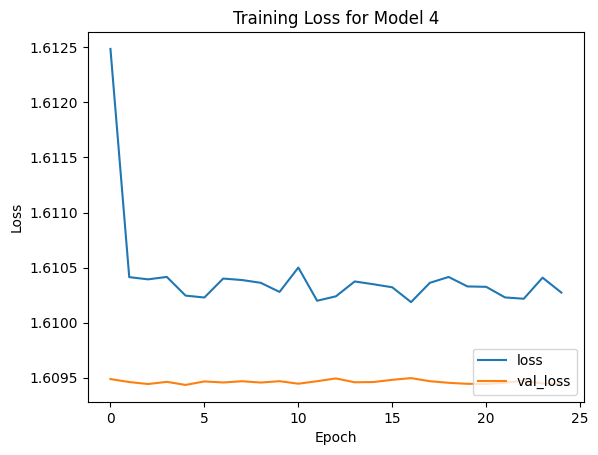

In [ ]:
plt.title('Training Loss for Model 4')
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_4.load_weights('model_4_best.hdf5')

In [ ]:
val_loss, val_acc = model_4.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 3s 5ms/step - loss: 1.6094 - accuracy: 0.2000
Accuracy: 20.000000298023224
Loss:1.6094344854354858


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_4.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.2
Precision: 0.04000000000000001
Recall: 0.2
F1 Score: 0.06666666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###2.5 Model 5 - Deep Model with 9 Convolutional Layers

Model Structure:
- 9 Convolutional layers with 64, 48, 32, 16 and 8 kernels, each using a relu activation function
- 3 MaxPool layers with (2,2) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function


In [ ]:
model_5 = Sequential()
model_5.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(48, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_5.add(layers.Conv2D(8, (3, 3), activation='relu'))
model_5.add( Flatten() )
model_5.add( Dense(5, activation = 'softmax' ) )

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 conv2d_23 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 46, 46, 48)        27696     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 23, 23, 48)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 21, 21, 32)       

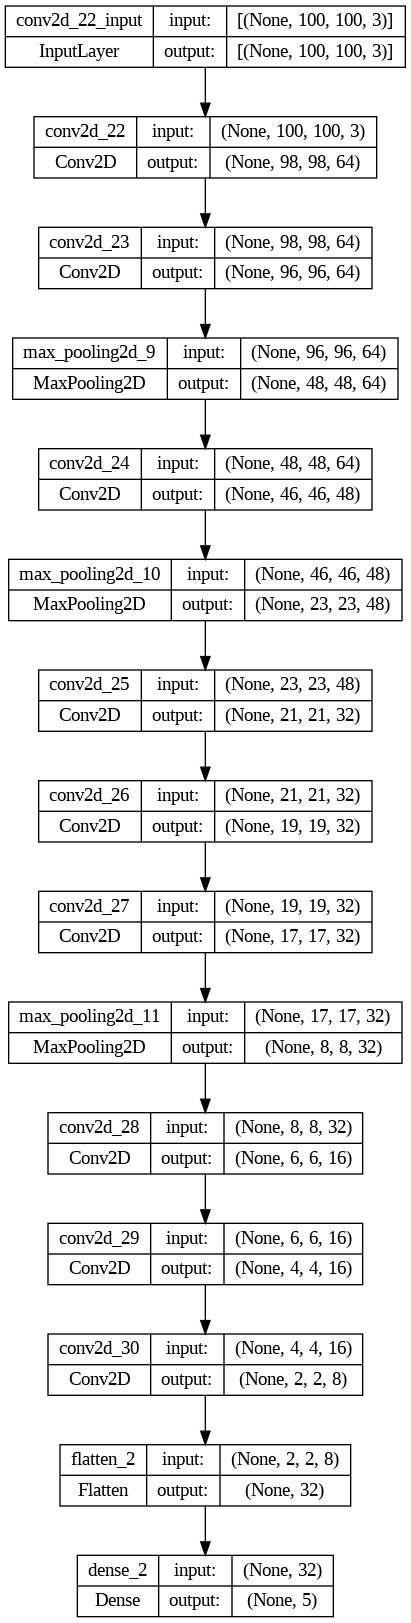

In [ ]:
tf.keras.utils.plot_model(model_5, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_5_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_5.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history5 = model_5.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1590/1590 [==============================] - ETA: 0s - loss: 1.6109 - accuracy: 0.1723
Epoch 1: val_loss improved from inf to 1.60945, saving model to model_5_best.hdf5
1590/1590 [==============================] - 26s 14ms/step - loss: 1.6109 - accuracy: 0.1723 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.6103 - accuracy: 0.1671
Epoch 2: val_loss improved from 1.60945 to 1.60944, saving model to model_5_best.hdf5
1590/1590 [==============================] - 26s 16ms/step - loss: 1.6103 - accuracy: 0.1673 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.6103 - accuracy: 0.1894
Epoch 3: val_loss did not improve from 1.60944
1590/1590 [==============================] - 23s 14ms/step - loss: 1.6103 - accuracy: 0.1893 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.6104 - a

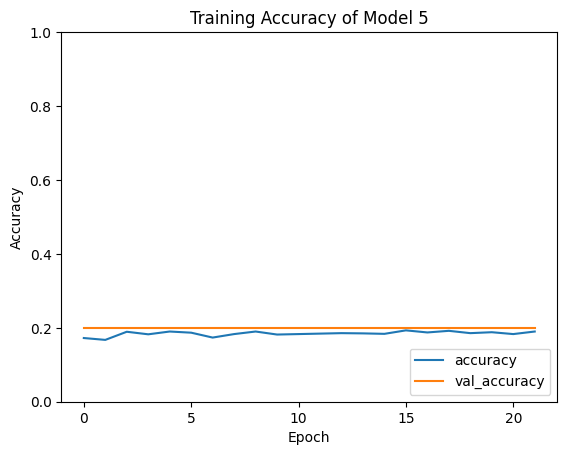

In [ ]:
plt.title('Training Accuracy of Model 5')
plt.plot(history5.history['accuracy'], label='accuracy')
plt.plot(history5.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

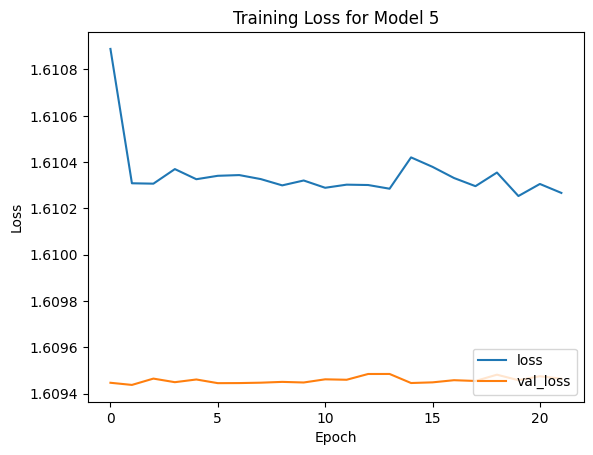

In [ ]:
plt.title('Training Loss for Model 5')
plt.plot(history5.history['loss'], label='loss')
plt.plot(history5.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_5.load_weights('model_5_best.hdf5')

In [ ]:
val_loss, val_acc = model_5.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 3s 6ms/step - loss: 1.6094 - accuracy: 0.2000
Accuracy: 20.000000298023224
Loss:1.6094377040863037


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_5.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.2
Precision: 0.04000000000000001
Recall: 0.2
F1 Score: 0.06666666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###2.6 Model 6 Only 1 Convolutional Layer

Model Structure:
- 1 Convolutional layers with 32 kernels using a relu activation function
- 1 MaxPool layers with (9,9) pooling windows
- 1 Flatten Layer after the convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

This experiment is to see what happens when you only have 1 convolutional layer in the CNN.

In [ ]:
model_6 = Sequential()
model_6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_6.add(layers.MaxPooling2D((9,9)))
model_6.add( Flatten() )
model_6.add( Dense(5, activation = 'softmax' ) )

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 16005     
                                                                 
Total params: 16901 (66.02 KB)
Trainable params: 16901 (66.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


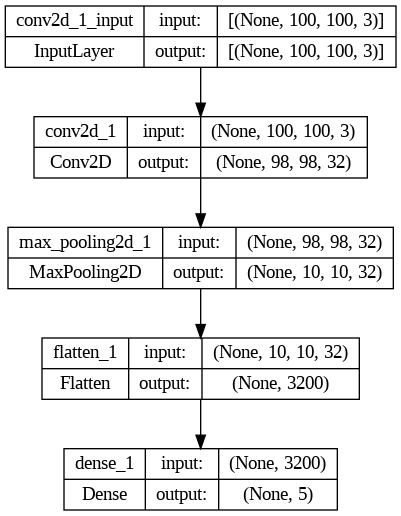

In [ ]:
tf.keras.utils.plot_model(model_6, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_6_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_6.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history6 = model_6.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.3198 - accuracy: 0.4588
Epoch 1: val_loss improved from inf to 1.14645, saving model to model_6_best.hdf5
1590/1590 [==============================] - 19s 11ms/step - loss: 1.3193 - accuracy: 0.4591 - val_loss: 1.1465 - val_accuracy: 0.5245
Epoch 2/100
1582/1590 [============================>.] - ETA: 0s - loss: 0.8447 - accuracy: 0.6960
Epoch 2: val_loss improved from 1.14645 to 0.85109, saving model to model_6_best.hdf5
1590/1590 [==============================] - 15s 10ms/step - loss: 0.8448 - accuracy: 0.6956 - val_loss: 0.8511 - val_accuracy: 0.7057
Epoch 3/100
1585/1590 [============================>.] - ETA: 0s - loss: 0.6751 - accuracy: 0.7590
Epoch 3: val_loss improved from 0.85109 to 0.79351, saving model to model_6_best.hdf5
1590/1590 [==============================] - 15s 9ms/step - loss: 0.6742 - accuracy: 0.7591 - val_loss: 0.7935 - val_accuracy: 0.7170
Epoch 4/100
1584/1590 [======================

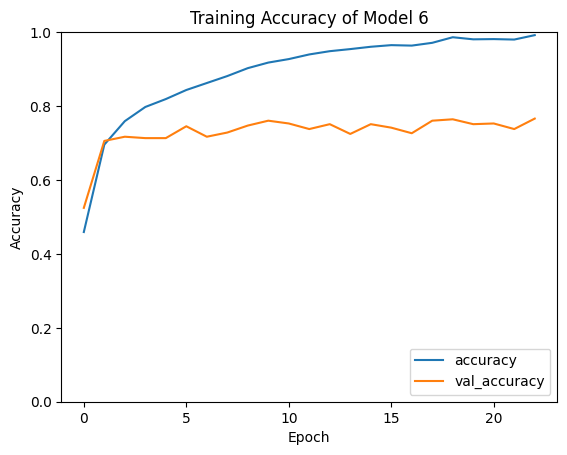

In [ ]:
plt.title('Training Accuracy of Model 6')
plt.plot(history6.history['accuracy'], label='accuracy')
plt.plot(history6.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

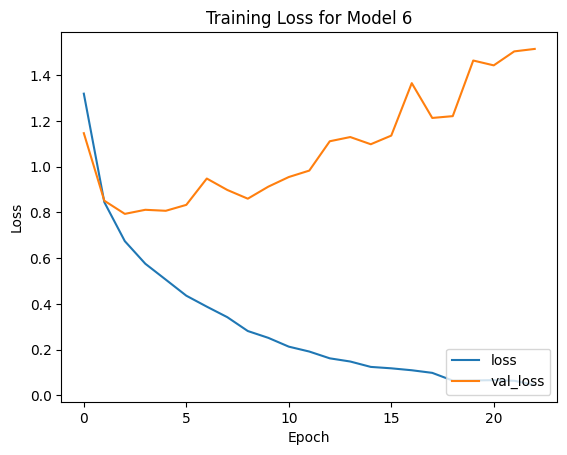

In [ ]:
plt.title('Training Loss for Model 6')
plt.plot(history6.history['loss'], label='loss')
plt.plot(history6.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_6.load_weights('model_6_best.hdf5')

In [ ]:
val_loss, val_acc = model_6.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.7935 - accuracy: 0.7170
Accuracy: 71.69811129570007
Loss:0.7935149669647217


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_6.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7169811320754716
Precision: 0.7328029516238558
Recall: 0.7169811320754716
F1 Score: 0.7174450955234579


##Experiments with the Number of Filters

###2.6 Model 7 Using lots of Filters

Model Structure:
- 3 Convolutional layers with 200, 100, 50 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (5,5) and (3,3) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function



In [ ]:
model_7 = Sequential()

model_7.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_7.add(layers.MaxPooling2D((5,5)))
model_7.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((3, 3)))
model_7.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_7.add( Flatten() )
model_7.add( Dense(5, activation = 'softmax' ) )

model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 19, 19, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 5, 5, 100)         0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 3, 3, 50)          45050     
                                                                 
 flatten_3 (Flatten)         (None, 450)              

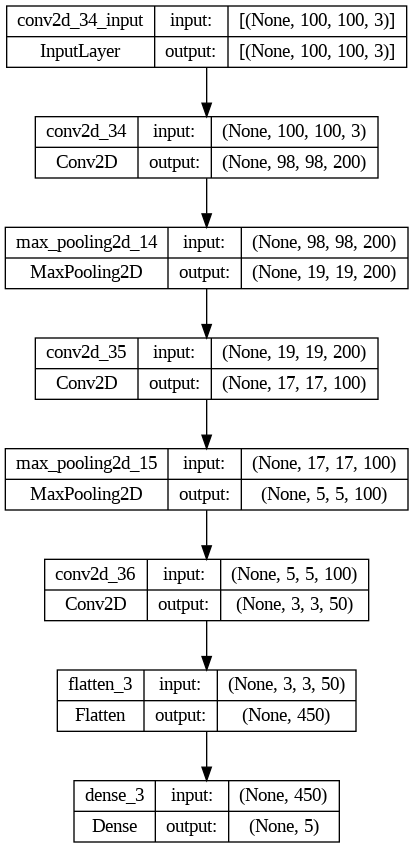

In [ ]:
tf.keras.utils.plot_model(model_7, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_7_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history7 = model_7.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.5678 - accuracy: 0.2617
Epoch 1: val_loss improved from inf to 1.35709, saving model to model_7_best.hdf5
1590/1590 [==============================] - 14s 7ms/step - loss: 1.5690 - accuracy: 0.2616 - val_loss: 1.3571 - val_accuracy: 0.4283
Epoch 2/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.1029 - accuracy: 0.5744
Epoch 2: val_loss improved from 1.35709 to 1.08695, saving model to model_7_best.hdf5
1590/1590 [==============================] - 13s 8ms/step - loss: 1.1019 - accuracy: 0.5748 - val_loss: 1.0870 - val_accuracy: 0.5660
Epoch 3/100
1583/1590 [============================>.] - ETA: 0s - loss: 0.9326 - accuracy: 0.6443
Epoch 3: val_loss improved from 1.08695 to 0.88625, saving model to model_7_best.hdf5
1590/1590 [==============================] - 11s 7ms/step - loss: 0.9312 - accuracy: 0.6453 - val_loss: 0.8863 - val_accuracy: 0.6717
Epoch 4/100
1580/1590 [========================

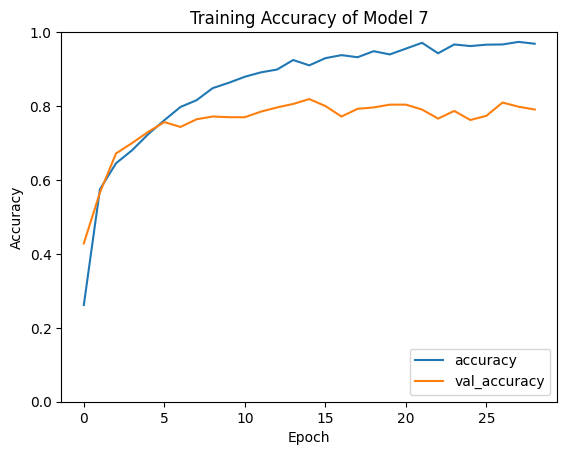

In [ ]:
plt.title('Training Accuracy of Model 7')
plt.plot(history7.history['accuracy'], label='accuracy')
plt.plot(history7.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

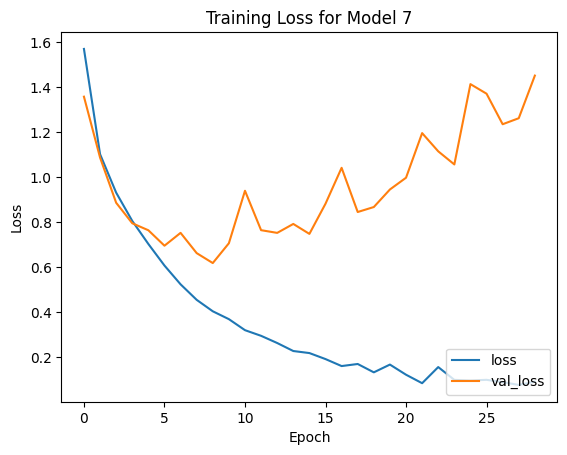

In [ ]:
plt.title('Training Loss for Model 7')
plt.plot(history7.history['loss'], label='loss')
plt.plot(history7.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_7.load_weights('model_7_best.hdf5')

In [ ]:
val_loss, val_acc = model_7.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 2s 4ms/step - loss: 0.6187 - accuracy: 0.7717
Accuracy: 77.16981172561646
Loss:0.6186827421188354


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_7.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7716981132075472
Precision: 0.7726862682501292
Recall: 0.7716981132075472
F1 Score: 0.7675639225585091


### 2.8 Model 8 Only 1 Convolutional Filter
Model Structure:
- 1 Convolutional layers with 1 kernel using a relu activation function
- 1 MaxPool layers with (9,9) pooling window
- 1 Flatten Layer after the convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function

This model is built using only 1 convolutional layer and 1 filter to see what happens when you build a model with not enough filters.

In [ ]:
model_8 = Sequential()
model_8.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_8.add(layers.MaxPooling2D((9,9)))
model_8.add(Flatten() )
model_8.add(Dense(5, activation = 'softmax' ) )

model_8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 98, 98, 1)         28        
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 10, 10, 1)         0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


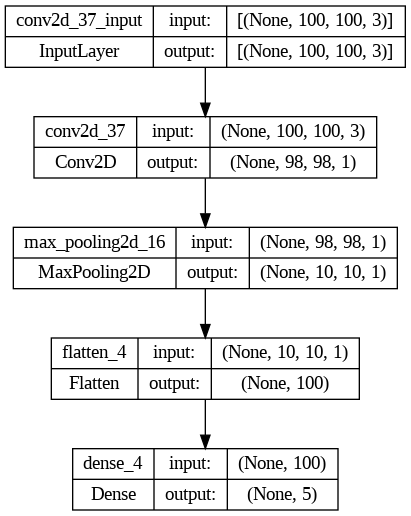

In [ ]:
tf.keras.utils.plot_model(model_8, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_8_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_8.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history8 = model_8.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.5380 - accuracy: 0.2799
Epoch 1: val_loss improved from inf to 1.36911, saving model to model_8_best.hdf5
1590/1590 [==============================] - 13s 7ms/step - loss: 1.5374 - accuracy: 0.2805 - val_loss: 1.3691 - val_accuracy: 0.4717
Epoch 2/100
1581/1590 [============================>.] - ETA: 0s - loss: 1.3037 - accuracy: 0.4959
Epoch 2: val_loss improved from 1.36911 to 1.28647, saving model to model_8_best.hdf5
1590/1590 [==============================] - 9s 5ms/step - loss: 1.3043 - accuracy: 0.4956 - val_loss: 1.2865 - val_accuracy: 0.4943
Epoch 3/100
1590/1590 [==============================] - ETA: 0s - loss: 1.2175 - accuracy: 0.5314
Epoch 3: val_loss improved from 1.28647 to 1.27581, saving model to model_8_best.hdf5
1590/1590 [==============================] - 10s 6ms/step - loss: 1.2175 - accuracy: 0.5314 - val_loss: 1.2758 - val_accuracy: 0.5000
Epoch 4/100
1576/1590 [=========================

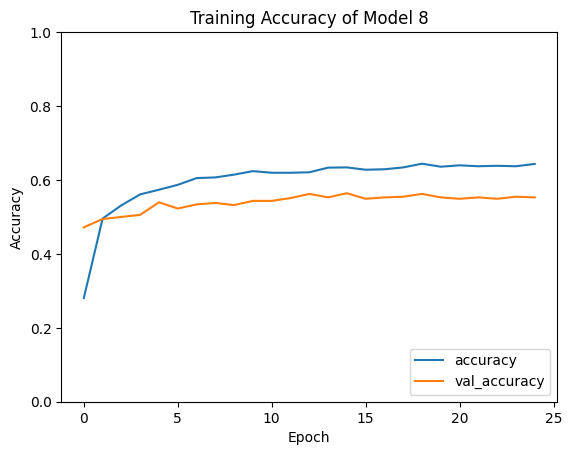

In [ ]:
plt.title('Training Accuracy of Model 8')
plt.plot(history8.history['accuracy'], label='accuracy')
plt.plot(history8.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

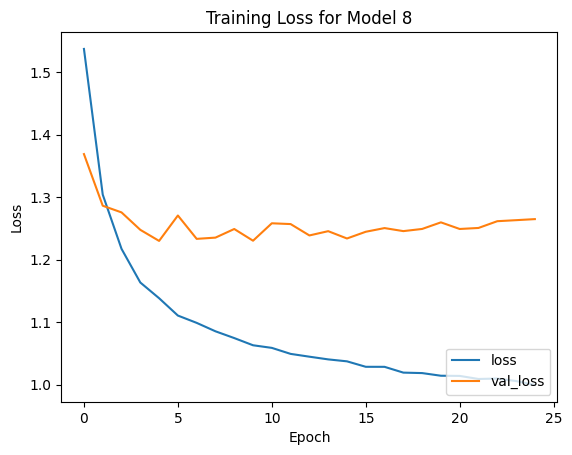

In [ ]:
plt.title('Training Loss for Model 8')
plt.plot(history8.history['loss'], label='loss')
plt.plot(history8.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_8.load_weights('model_8_best.hdf5')

In [ ]:
val_loss, val_acc = model_8.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 4s 7ms/step - loss: 1.2302 - accuracy: 0.5396
Accuracy: 53.96226644515991
Loss:1.2301889657974243


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_8.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.539622641509434
Precision: 0.5464166042374998
Recall: 0.539622641509434
F1 Score: 0.5379556075085777


###2.9 Model 9 Using Even More Filters

Model Structure:
- 3 Convolutional layers with 400, 200, 100 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (4,4) and (4,4) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function

In [ ]:
model_9 = Sequential()
model_9.add(layers.Conv2D(400, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_9.add(layers.MaxPooling2D((4, 4)))
model_9.add(layers.Conv2D(200, (3, 3), activation='relu'))
model_9.add(layers.MaxPooling2D((4, 4)))
model_9.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_9.add( Flatten() )
model_9.add( Dense(5, activation = 'softmax' ) )

model_9.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 98, 98, 400)       11200     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 24, 24, 400)       0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 22, 22, 200)       720200    
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 5, 5, 200)         0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 3, 3, 100)         180100    
                                                                 
 flatten_7 (Flatten)         (None, 900)             

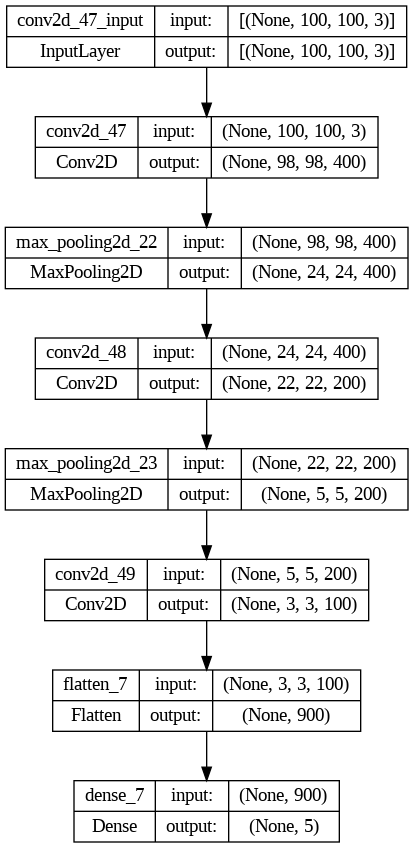

In [ ]:
tf.keras.utils.plot_model(model_9, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_9_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_9.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history9 = model_9.fit(training_data, validation_data = validation_set, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.4709 - accuracy: 0.3556
Epoch 1: val_loss improved from inf to 1.24603, saving model to model_9_best.hdf5
1590/1590 [==============================] - 18s 10ms/step - loss: 1.4707 - accuracy: 0.3553 - val_loss: 1.2460 - val_accuracy: 0.5000
Epoch 2/100
1587/1590 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.5929
Epoch 2: val_loss improved from 1.24603 to 0.92419, saving model to model_9_best.hdf5
1590/1590 [==============================] - 23s 14ms/step - loss: 1.0376 - accuracy: 0.5931 - val_loss: 0.9242 - val_accuracy: 0.6547
Epoch 3/100
1587/1590 [============================>.] - ETA: 0s - loss: 0.7854 - accuracy: 0.7095
Epoch 3: val_loss improved from 0.92419 to 0.79946, saving model to model_9_best.hdf5
1590/1590 [==============================] - 14s 9ms/step - loss: 0.7860 - accuracy: 0.7094 - val_loss: 0.7995 - val_accuracy: 0.7151
Epoch 4/100
1587/1590 [======================

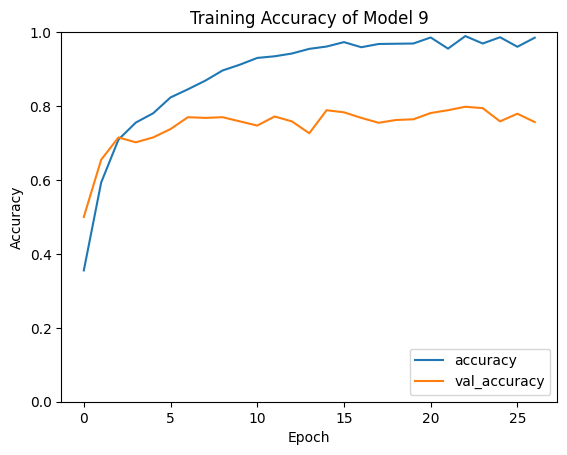

In [ ]:
plt.title('Training Accuracy of Model 9')
plt.plot(history9.history['accuracy'], label='accuracy')
plt.plot(history9.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

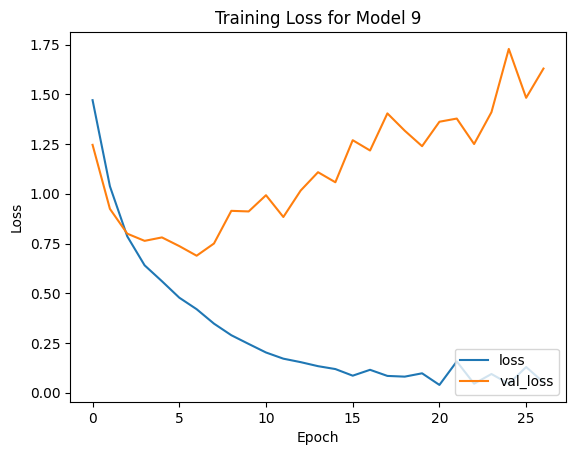

In [ ]:
plt.title('Training Loss for Model 9')
plt.plot(history9.history['loss'], label='loss')
plt.plot(history9.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_9.load_weights('model_9_best.hdf5')

In [ ]:
val_loss, val_acc = model_9.evaluate(validation_set)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 4s 7ms/step - loss: 0.6887 - accuracy: 0.7698
Accuracy: 76.98113322257996
Loss:0.6886632442474365


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set)):
   x, y = validation_set.next()
   p = model_9.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.769811320754717
Precision: 0.7711883257097165
Recall: 0.769811320754717
F1 Score: 0.7697660009420869


##Experiments with Changing the Image Size

### Create Different Sized Images

In [ ]:
smaller_size = 32
larger_size = 200

image_generator = ImageDataGenerator(rescale=1./255)

# Create a Small Image training set
print(f"Small Image Sets {smaller_size}x{smaller_size}")
training_data_32 = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(smaller_size, smaller_size), batch_size=1, class_mode='categorical')
print(f"Training Set: {training_data_32.image_shape}")

validation_set_32 = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(smaller_size, smaller_size), batch_size=1, class_mode='categorical')
print(f"Validation Set: {validation_set_32.image_shape}")

testing_set_32 = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/testing', target_size=(smaller_size, smaller_size), batch_size=1, class_mode='categorical')
print(f"Testing Set: {testing_set_32.image_shape}")

# Create a Large Image training set
print(f"\nLarge Image Sets {larger_size}x{larger_size}")
training_data_200 = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/training', target_size=(larger_size,larger_size), batch_size=1, class_mode='categorical')
print(f"Training Set: {training_data_200.image_shape}")

validation_set_200 = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/validation', target_size=(larger_size,larger_size), batch_size=1, class_mode='categorical')
print(f"Validation Set: {validation_set_200.image_shape}")

testing_set_200 = image_generator.flow_from_directory( '/tmp/Cropped_Split_Data/testing', target_size=(larger_size,larger_size), batch_size=1, class_mode='categorical')
print(f"Testing Set: {testing_set_200.image_shape}")


Small Image Sets 32x32
Found 1590 images belonging to 5 classes.
Training Set: (32, 32, 3)
Found 530 images belonging to 5 classes.
Validation Set: (32, 32, 3)
Found 530 images belonging to 5 classes.
Testing Set: (32, 32, 3)

Large Image Sets 200x200
Found 1590 images belonging to 5 classes.
Training Set: (200, 200, 3)
Found 530 images belonging to 5 classes.
Validation Set: (200, 200, 3)
Found 530 images belonging to 5 classes.
Testing Set: (200, 200, 3)


###2. Model 10 using 32x32 Images
Model Structure:
- 2 Convolutional layers with 100, 50 kernels, each using a relu activation function
- 1 MaxPool layers that follow the first and second convolutional layers with (2,2) pooling windows
- 1 Flatten Layer
- 1 Dense layer with 5 neurons using a softmax activation function

This model is based off Model 3 but instead of taking 256x256 images it takes a 48x48 images as input.

In [ ]:
model_10 = Sequential()

model_10.add(layers.Conv2D(100, (3, 3), activation='relu',input_shape=training_data_32.image_shape))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_10.add( Flatten() )
model_10.add( Dense(5, activation = 'softmax' ) )

model_10.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 30, 30, 100)       2800      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 15, 15, 100)       0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 13, 13, 50)        45050     
                                                                 
 flatten_10 (Flatten)        (None, 8450)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 42255     
                                                                 
Total params: 90105 (351.97 KB)
Trainable params: 90105 (351.97 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

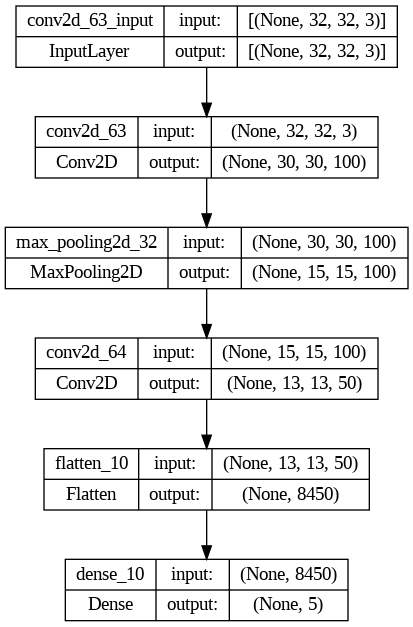

In [ ]:
tf.keras.utils.plot_model(model_10, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_10_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_10.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history10 = model_10.fit(training_data_32, validation_data = validation_set_32, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.6003 - accuracy: 0.2390
Epoch 1: val_loss improved from inf to 1.51099, saving model to model_10_best.hdf5
1590/1590 [==============================] - 15s 8ms/step - loss: 1.6001 - accuracy: 0.2396 - val_loss: 1.5110 - val_accuracy: 0.3132
Epoch 2/100
1588/1590 [============================>.] - ETA: 0s - loss: 1.3982 - accuracy: 0.3992
Epoch 2: val_loss improved from 1.51099 to 1.28044, saving model to model_10_best.hdf5
1590/1590 [==============================] - 13s 8ms/step - loss: 1.3984 - accuracy: 0.3987 - val_loss: 1.2804 - val_accuracy: 0.5509
Epoch 3/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.0911 - accuracy: 0.5687
Epoch 3: val_loss improved from 1.28044 to 1.03509, saving model to model_10_best.hdf5
1590/1590 [==============================] - 17s 11ms/step - loss: 1.0912 - accuracy: 0.5686 - val_loss: 1.0351 - val_accuracy: 0.6132
Epoch 4/100
1578/1590 [====================

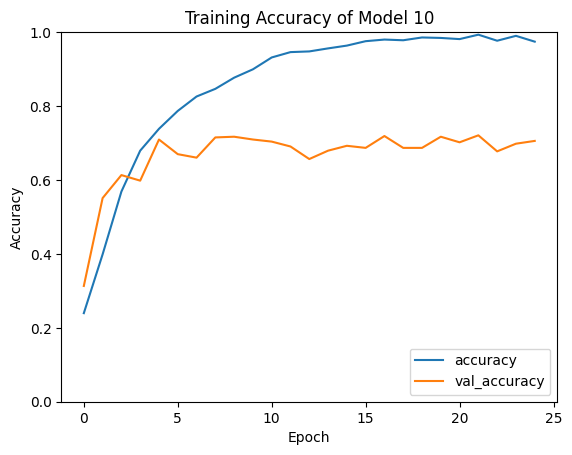

In [ ]:
plt.title('Training Accuracy of Model 10')
plt.plot(history10.history['accuracy'], label='accuracy')
plt.plot(history10.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

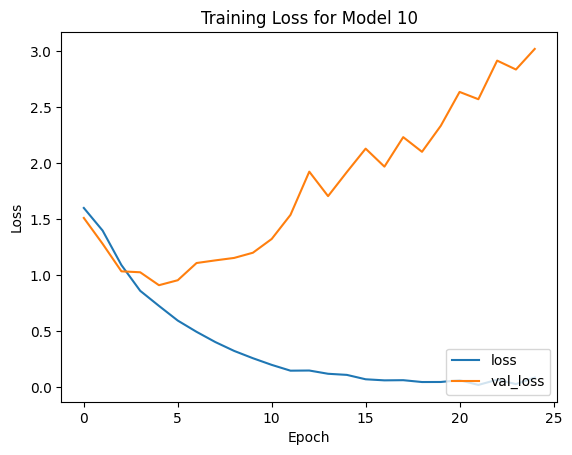

In [ ]:
plt.title('Training Loss for Model 10')
plt.plot(history10.history['loss'], label='loss')
plt.plot(history10.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_10.load_weights('model_10_best.hdf5')

In [ ]:
val_loss, val_acc = model_10.evaluate(validation_set_32)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 3s 5ms/step - loss: 0.9114 - accuracy: 0.7094
Accuracy: 70.94339728355408
Loss:0.9113784432411194


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set_32)):
   x, y = validation_set_32.next()
   p = model_10.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7094339622641509
Precision: 0.7033418756642691
Recall: 0.7094339622641509
F1 Score: 0.6906120457209853


###2. Model 11 using 200x200 Images

Model Structure:
- 3 Convolutional layers with 200, 100, 50 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (5,5) and (3,3) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 5 neurons using a softmax activation function

In [ ]:
model_11 = Sequential()

model_11.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=training_data_200.image_shape))
model_11.add(layers.MaxPooling2D((5,5)))
model_11.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_11.add(layers.MaxPooling2D((3, 3)))
model_11.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_11.add( Flatten() )
model_11.add( Dense(5, activation = 'softmax' ) )

model_11.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 198, 198, 200)     5600      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 39, 39, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 37, 37, 100)       180100    
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 12, 12, 100)       0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 10, 10, 50)        45050     
                                                                 
 flatten_11 (Flatten)        (None, 5000)            

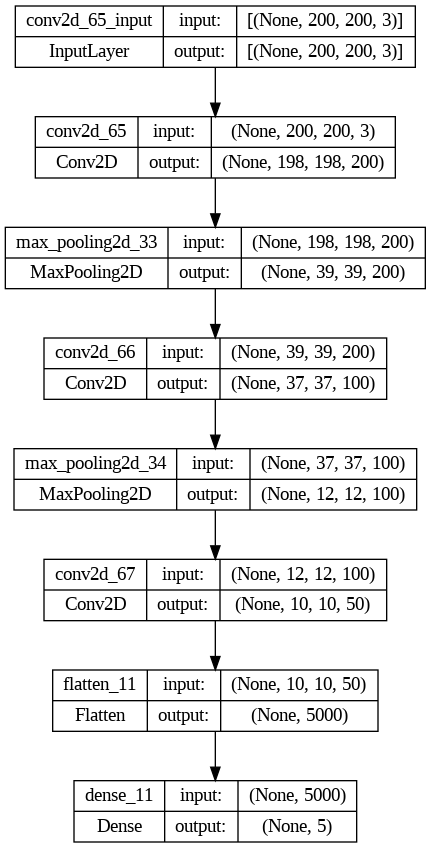

In [ ]:
tf.keras.utils.plot_model(model_11, show_layer_names=True, show_shapes=True)

In [ ]:
callback_a = ModelCheckpoint(filepath = 'model_11_best.hdf5', monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose=1)
model_11.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
history11 = model_11.fit(training_data_200, validation_data = validation_set_200, epochs = 100, batch_size = 64, callbacks = [callback_a, callback_b])

Epoch 1/100
1585/1590 [============================>.] - ETA: 0s - loss: 1.6175 - accuracy: 0.2057
Epoch 1: val_loss improved from inf to 1.60959, saving model to model_11_best.hdf5
1590/1590 [==============================] - 15s 9ms/step - loss: 1.6175 - accuracy: 0.2063 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 2/100
1589/1590 [============================>.] - ETA: 0s - loss: 1.6104 - accuracy: 0.1913
Epoch 2: val_loss improved from 1.60959 to 1.60950, saving model to model_11_best.hdf5
1590/1590 [==============================] - 13s 8ms/step - loss: 1.6104 - accuracy: 0.1912 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/100
1586/1590 [============================>.] - ETA: 0s - loss: 1.6203 - accuracy: 0.1734
Epoch 3: val_loss did not improve from 1.60950
1590/1590 [==============================] - 13s 8ms/step - loss: 1.6203 - accuracy: 0.1736 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/100
1582/1590 [============================>.] - ETA: 0s - loss: 1.6104 - ac

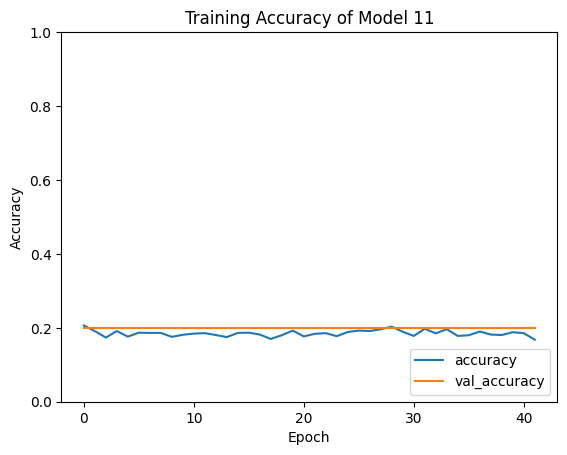

In [ ]:
plt.title('Training Accuracy of Model 11')
plt.plot(history11.history['accuracy'], label='accuracy')
plt.plot(history11.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

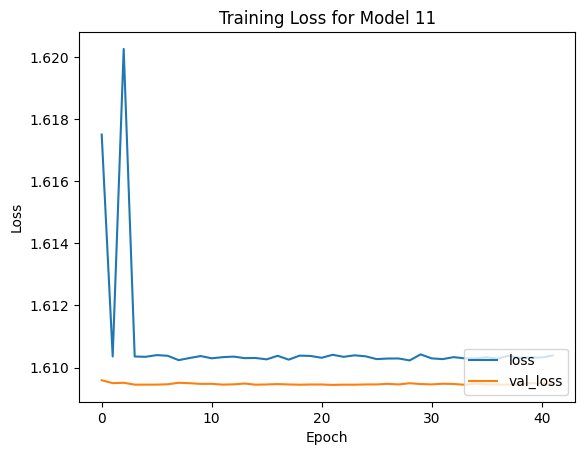

In [ ]:
plt.title('Training Loss for Model 11')
plt.plot(history11.history['loss'], label='loss')
plt.plot(history11.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_11.load_weights('model_11_best.hdf5')

In [ ]:
val_loss, val_acc = model_11.evaluate(validation_set_200)

print(f'Accuracy: {val_acc*100.0}')
print(f'Loss:{val_loss}')

530/530 [==============================] - 3s 7ms/step - loss: 1.6094 - accuracy: 0.2000
Accuracy: 20.000000298023224
Loss:1.6094399690628052


In [ ]:
# Get predictions from model
P = [] # empty list of predictions
Y_true = []
for i in range(len(validation_set_200)):
   x, y = validation_set_200.next()
   p = model_11.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.2
Precision: 0.04000000000000001
Recall: 0.2
F1 Score: 0.06666666666666667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##3. Evaluate Best Model on the Testing Dataset
Since Model 2 and 7 both did well on the validation set with approximately 75% and 77% percent on the validation set I decided to evaluate both of them on the independent testing set.

###3.1 Evaluation of Model 2 on the Testing Set

Model Structure:
- 3 Convolutional layers with 64, 32 and 16 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (4,4) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function

In [ ]:
model_2 = Sequential()

model_2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_2.add(layers.MaxPooling2D((4, 4)))
model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((4, 4)))
model_2.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_2.add( Flatten() )
model_2.add( Dense(5, activation = 'softmax' ) )

model_2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (None, 3, 3, 16)          4624      
                                                                 
 flatten_12 (Flatten)        (None, 144)             

In [ ]:
model_2.load_weights('model_2_best.hdf5')

In [ ]:
# Get predictions from model 3 on testing set
P = [] # empty list of predictions
Y_true = []
for i in range(len(testing_set)):
   x, y = testing_set.next()
   p = model_2.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8056603773584906
Precision: 0.8062275425259349
Recall: 0.8056603773584906
F1 Score: 0.8051371225640432


###3.2 Evaluation of Model 7 on the Testing Set

Model Structure:
- 3 Convolutional layers with 200, 100, 50 kernels, each using a relu activation function
- 2 MaxPool layers that follow the first and second convolutional layers with (5,5) and (3,3) pooling windows
- 1 Flatten Layer after the 3rd convolutional layer
- 1 Dense layer with 3 neurons using a softmax activation function


In [ ]:
model_7 = Sequential()

model_7.add(layers.Conv2D(200, (3, 3), activation='relu', input_shape=training_data.image_shape))
model_7.add(layers.MaxPooling2D((5,5)))
model_7.add(layers.Conv2D(100, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((3, 3)))
model_7.add(layers.Conv2D(50, (3, 3), activation='relu'))
model_7.add( Flatten() )
model_7.add( Dense(5, activation = 'softmax' ) )

model_7.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 98, 98, 200)       5600      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 19, 19, 200)       0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 17, 17, 100)       180100    
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 5, 5, 100)         0         
 ng2D)                                                           
                                                                 
 conv2d_73 (Conv2D)          (None, 3, 3, 50)          45050     
                                                                 
 flatten_13 (Flatten)        (None, 450)             

In [ ]:
model_7.load_weights('model_7_best.hdf5')

In [ ]:
# Get predictions from model 3 on testing set
P = [] # empty list of predictions
Y_true = []
for i in range(len(testing_set)):
   x, y = testing_set.next()
   p = model_7.predict(x, verbose = 0)
   Y_true.extend(y)
   P.extend(p)

In [ ]:
# Convert predicted probabilities to binary predictions (0 or 1)
Y_pred = np.argmax(P, axis=1)
Y_true = np.argmax(Y_true, axis=1)

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7584905660377359
Precision: 0.7677856589621295
Recall: 0.7584905660377359
F1 Score: 0.7555527943793001


#3.4 Testing Set Conclusion
Surprisingly Model 2 which did not perform as well on the validation set performed best on the testing set with a 80.57%. Model 7 did best on the validation and only slightly worse on the testing set so the patterns it learned were consistent in all datasets.